## **1. Import**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import numpy as np

import seaborn as sns
sns.set_theme(rc={'figure.figsize':(8,6)})

import matplotlib.pyplot as plt

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AX4XfWiCoXUxdhJ6kpEKHsHsLSQ1bnMlw1NzHdbl6Ssqz15qSlJEes7Q74g
Mounted at /content/drive


In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 37.8 gigabytes of available RAM

You are using a high-RAM runtime!


## **2. Define Hyperparametres**

In [ ]:
#FILE = "/content/drive/MyDrive/GBPUSD_20210902/GBPUSD_201109_202108.csv"

#TRADING_START_DATE = pd.Timestamp(2011,10,1,0,0,0,0)
DAYS = 30
FREQUENCY = 15
DELTA_PERCENTAGE = 0

NUM_OF_LINES = 3

INITIAL_GBP_BALANCE = 5000 #此数字可任意调整

DAYS_TIMEDELTA = pd.Timedelta(DAYS,unit='days')
FREQUENCY_TIMEDELTA = pd.Timedelta(FREQUENCY,unit='days')


## **3. Defining Functions**

In [ ]:
# CALCULATE THE TEN LINES
def calculate_ten_lines(sub_trading_start_date):
  #df_Jul
  df_Jul = df[(df['Timestamp'] >= (sub_trading_start_date - DAYS_TIMEDELTA)) & (df['Timestamp'] < sub_trading_start_date)]
  df_Jul['mid_price'] = (df_Jul['Bid price'] + df_Jul['Ask price'])/2
  df_Jul['time_delta'] = (df_Jul['Timestamp'].shift(-1) - df_Jul['Timestamp'])
  
  mean_Jul = ((df_Jul['time_delta'] * df_Jul['mid_price']).sum()) / (df_Jul['Timestamp'].iloc[-1] - df_Jul['Timestamp'].iloc[0]) #此算法可以调整
  max_Jul_bid = df_Jul['Bid price'].max()
  min_Jul_ask = df_Jul['Ask price'].min()

  delta = (max_Jul_bid - min_Jul_ask) * DELTA_PERCENTAGE # 0这个数字可以调
  max_Jul_bid += delta
  min_Jul_ask -= delta

  sell_lines = np.arange(mean_Jul,max_Jul_bid+0.000001,(max_Jul_bid-mean_Jul)/NUM_OF_LINES) #sell_lines的生成方式可以调整
  buy_lines = np.arange(min_Jul_ask,mean_Jul,(mean_Jul-min_Jul_ask)/NUM_OF_LINES) #buy_lines的生成方式可以调整
  lines = np.concatenate((buy_lines,sell_lines))

  df_Aug = df[(df['Timestamp'] >= sub_trading_start_date) & (df['Timestamp'] < (sub_trading_start_date + FREQUENCY_TIMEDELTA))]
  df_Aug = df_Aug.reset_index(drop=True)

  return (lines, df_Aug)

In [ ]:
def trade(SUB_TRADING_START_DATES):
  #Initialization for Trading
  trading_lines_history_status = []
  trading_prices_history_status = []
  trading_history_status = {}

  #Trading Process
  for s in SUB_TRADING_START_DATES:
    (lines, df_Aug) = calculate_ten_lines(s)
    df_trading = df_Aug.copy()

    MID_PRICE_AT_INDEX_ZERO = (df_trading.iloc[0]['Ask price'] + df_trading.iloc[0]['Bid price']) / 2
    temp = list(lines > MID_PRICE_AT_INDEX_ZERO).count(False)
    current_two_lines_status = [temp-1, temp]
    latest_line_status = temp - 0.3

    while True:

      if (0 < latest_line_status < (len(lines)-1)):
        df_temp = df_trading[(df_trading['Ask price'] <= lines[current_two_lines_status[0]]) | (df_trading['Bid price'] >= lines[current_two_lines_status[1]])]
        if len(df_temp) == 0:
          break
        latest_trading_index_status = df_temp.iloc[0].name 

        if df_trading.loc[latest_trading_index_status]['Bid price'] >= lines[current_two_lines_status[1]]:
          latest_line_status = int(latest_line_status + 1) #这个操作主要是为了照顾到第1次交易时，latest_trading_index_status的初始状态是个小数（x.7）
          if (lines[current_two_lines_status[1]]) > standard_exchange_rate:
            trading_history_status[latest_trading_index_status] = 'sell'
          else:
            trading_history_status[latest_trading_index_status] = 'null'
        else:
          latest_line_status = round(latest_line_status - 1) #这个操作主要是为了照顾到第1次交易时，latest_trading_index_status的初始状态是个小数（x.7）
          if (lines[current_two_lines_status[0]]) < standard_exchange_rate:
            trading_history_status[latest_trading_index_status] = 'buy'
          else:
            trading_history_status[latest_trading_index_status] = 'null'

      elif latest_line_status >= (len(lines)-1):
        df_temp = df_trading[(df_trading['Ask price'] <= lines[-2])]
        if len(df_temp) == 0:
          break
        latest_trading_index_status = df_temp.iloc[0].name

        latest_line_status = len(lines) - 2

        if (lines[-2] < standard_exchange_rate):
          trading_history_status[latest_trading_index_status] = 'buy'
        else:
          trading_history_status[latest_trading_index_status] = 'null'

      elif latest_line_status <= 0:
        df_temp = df_trading[(df_trading['Bid price'] >= lines[1])]
        if len(df_temp) == 0:
          break
        latest_trading_index_status = df_temp.iloc[0].name

        latest_line_status = 1 

        if (lines[1] > standard_exchange_rate):
          trading_history_status[latest_trading_index_status] = 'sell'
        else:
          trading_history_status[latest_trading_index_status] = 'null'
      
      current_two_lines_status = [latest_line_status-1,latest_line_status+1]

      trading_lines_history_status.append(latest_line_status)
      trading_prices_history_status.append(lines[latest_line_status])

      df_trading = df_trading.loc[(latest_trading_index_status+1):]


  list_buy_sell_or_null = list(trading_history_status.values())

  print('Length of list_buy_sell_or_null: ', len(list_buy_sell_or_null))
  print('list_buy_sell_or_null: ', list_buy_sell_or_null)
  print('trading_prices_history_status: ', trading_prices_history_status)

  return (list_buy_sell_or_null, trading_prices_history_status)


In [ ]:
#Calculate Profit
def calculate_profit():
  #Initialization for Calculating the Profit
  INVESTMENT_GBP_PER = INITIAL_GBP_BALANCE/NUM_OF_LINES

  data_temp = df[df['Timestamp'] >= TRADING_START_DATE].iloc[0]
  standard_exchange_rate = (data_temp['Bid price'] + data_temp['Ask price']) / 2

  INITIAL_USD_BALANCE = INITIAL_GBP_BALANCE * standard_exchange_rate

  TOTAL_COST_USD = INITIAL_GBP_BALANCE * standard_exchange_rate + INITIAL_USD_BALANCE
  TOTAL_COST_GBP = INITIAL_USD_BALANCE / standard_exchange_rate + INITIAL_GBP_BALANCE

  balance_usd_list = [INITIAL_USD_BALANCE]
  balance_gbp_list = [INITIAL_GBP_BALANCE]
  balance_equivalent_total_usd_list = [TOTAL_COST_USD]
  balance_equivalent_total_gbp_list = [TOTAL_COST_GBP]
  profit_rate_usd_list = [0]
  profit_rate_gbp_list = [0]

  #Calculating Process
  for i in range(len(list_buy_or_sell)):

    trading_price = trading_prices_history_status[i]
    
    if list_buy_or_sell[i] == 'buy':
      balance_usd = balance_usd_list[-1] - INVESTMENT_GBP_PER * trading_price
      balance_gbp = balance_gbp_list[-1] + INVESTMENT_GBP_PER
    elif list_buy_or_sell[i] == 'sell':
      balance_usd = balance_usd_list[-1] + INVESTMENT_GBP_PER * trading_price
      balance_gbp = balance_gbp_list[-1] - INVESTMENT_GBP_PER
    
    balance_equivalent_total_usd = balance_usd + balance_gbp * standard_exchange_rate
    balance_equivalent_total_gbp = balance_gbp + balance_usd / standard_exchange_rate

    profit_rate_usd = (balance_equivalent_total_usd - TOTAL_COST_USD) / TOTAL_COST_USD
    profit_rate_gbp = (balance_equivalent_total_gbp - TOTAL_COST_GBP) / TOTAL_COST_GBP

    balance_usd_list.append(balance_usd)
    balance_gbp_list.append(balance_gbp)

    balance_equivalent_total_usd_list.append(balance_equivalent_total_usd)
    balance_equivalent_total_gbp_list.append(balance_equivalent_total_gbp)

    profit_rate_usd_list.append(profit_rate_usd)
    profit_rate_gbp_list.append(profit_rate_gbp)

  balance_usd_list = np.array(balance_usd_list)
  balance_usd_list = np.round(balance_usd_list,2)
  balance_usd_list = list(balance_usd_list)
  balance_gbp_list = np.array(balance_gbp_list)
  balance_gbp_list = np.rint(balance_gbp_list)
  balance_gbp_list = list(balance_gbp_list)
  balance_equivalent_total_usd_list = np.array(balance_equivalent_total_usd_list)
  balance_equivalent_total_usd_list = np.round(balance_equivalent_total_usd_list,2)
  balance_equivalent_total_usd_list = list(balance_equivalent_total_usd_list)
  balance_equivalent_total_gbp_list = np.array(balance_equivalent_total_gbp_list)
  balance_equivalent_total_gbp_list = np.round(balance_equivalent_total_gbp_list,2)
  balance_equivalent_total_gbp_list = list(balance_equivalent_total_gbp_list)
  profit_rate_usd_list = np.array(profit_rate_usd_list)
  profit_rate_usd_list = np.round(profit_rate_usd_list,4)
  profit_rate_usd_list = list(profit_rate_usd_list)
  profit_rate_gbp_list = np.array(profit_rate_gbp_list)
  profit_rate_gbp_list = np.round(profit_rate_gbp_list,4)
  profit_rate_gbp_list = list(profit_rate_gbp_list)
    
  #最后一次交易之后的balance和profit（trading_price是最后一次交易的价格）
  #print('balance_usd_list: ',balance_usd_list)
  #print('balance_gbp_list: ',balance_gbp_list)
  #print('balance_equivalent_total_usd_list: ',balance_equivalent_total_usd_list)
  #print('balance_equivalent_total_gbp_list: ',balance_equivalent_total_gbp_list)
  #print('profit_rate_usd_list: ',profit_rate_usd_list)
  #print('profit_rate_gbp_list: ',profit_rate_gbp_list)

  return profit_rate_usd_list

## **Main Backtesting Loops**

In [ ]:
#1. n个1年的数据分别做backtesting，结果是n根线在一幅图上

for year in range(2012,2015): #可更改
  FILE = "/content/drive/MyDrive/GBPUSD_20210902/GBPUSD_" + str(year) + "09_" + str(year+1) + "08.csv"
  TRADING_START_DATE = pd.Timestamp(year,10,1,0,0,0,0)

  df = pd.read_csv(FILE)
  df['Timestamp'] = pd.to_datetime(df['Timestamp'], format="%Y%m%d %H:%M:%S:%f")

  SUB_TRADING_START_DATES = pd.date_range(start=TRADING_START_DATE, end=df['Timestamp'].iloc[-1], freq=FREQUENCY_TIMEDELTA)

  data_temp = df[df['Timestamp'] >= TRADING_START_DATE].iloc[0]
  standard_exchange_rate = (data_temp['Bid price'] + data_temp['Ask price']) / 2

  (list_buy_or_sell, trading_prices_history_status) = trade(SUB_TRADING_START_DATES)

  profit_rate_usd_list = calculate_profit()
  final_profit_rate_usd = profit_rate_usd_list[-1]

  df_result_plot = pd.DataFrame({'x':range(len(list_buy_or_sell)), 'y':profit_rate_usd_list[1:]})
  sns.lineplot(x='x', y='y', data=df_result_plot)


In [ ]:
#2-1. 将n个1年数据拼接成1个n年的数据（df），并做backtesting

START_YEAR = 2012 #可更改
END_YEAR = 2015 #可更改

TRADING_START_DATE = pd.Timestamp(START_YEAR,10,1,0,0,0,0)

df = pd.DataFrame()
for year in range(START_YEAR,END_YEAR):
  FILE = "/content/drive/MyDrive/GBPUSD_20210902/GBPUSD_" + str(year) + "09_" + str(year+1) + "08.csv"

  df_per = pd.read_csv(FILE)
  df = pd.concat([df,df_per], axis=0, ignore_index=True)

df['Timestamp'] = pd.to_datetime(df['Timestamp'], format="%Y%m%d %H:%M:%S:%f")

SUB_TRADING_START_DATES = pd.date_range(start=TRADING_START_DATE, end=df['Timestamp'].iloc[-1], freq=FREQUENCY_TIMEDELTA)

data_temp = df[df['Timestamp'] >= TRADING_START_DATE].iloc[0]
standard_exchange_rate = (data_temp['Bid price'] + data_temp['Ask price']) / 2

(list_buy_or_sell, trading_prices_history_status) = trade(SUB_TRADING_START_DATES)

profit_rate_usd_list = calculate_profit()
final_profit_rate_usd = profit_rate_usd_list[-1]

df_result_plot = pd.DataFrame({'x':range(len(list_buy_or_sell)), 'y':profit_rate_usd_list[1:]})
sns.lineplot(x='x', y='y', data=df_result_plot)




In [ ]:
#2.2 在上面的情境下加入tune NUM_OF_LINES

START_YEAR = 2016 #可更改
END_YEAR = 2021 #可更改

TRADING_START_DATE = pd.Timestamp(START_YEAR,10,1,0,0,0,0)

df = pd.DataFrame()
for year in range(START_YEAR,END_YEAR):
  FILE = "/content/drive/MyDrive/GBPUSD_20210902/GBPUSD_" + str(year) + "09_" + str(year+1) + "08.csv"

  df_per = pd.read_csv(FILE)
  df = pd.concat([df,df_per], axis=0, ignore_index=True)

df['Timestamp'] = pd.to_datetime(df['Timestamp'], format="%Y%m%d %H:%M:%S:%f")

SUB_TRADING_START_DATES = pd.date_range(start=TRADING_START_DATE, end=df['Timestamp'].iloc[-1], freq=FREQUENCY_TIMEDELTA)

data_temp = df[df['Timestamp'] >= TRADING_START_DATE].iloc[0]
standard_exchange_rate = (data_temp['Bid price'] + data_temp['Ask price']) / 2


Length of list_buy_sell_or_null:  162
list_buy_sell_or_null:  ['buy', 'null', 'buy', 'buy', 'null', 'buy', 'buy', 'buy', 'null', 'null', 'null', 'buy', 'buy', 'null', 'null', 'null', 'sell', 'sell', 'buy', 'buy', 'sell', 'buy', 'buy', 'sell', 'sell', 'sell', 'null', 'buy', 'sell', 'sell', 'null', 'null', 'sell', 'sell', 'sell', 'null', 'sell', 'sell', 'sell', 'sell', 'sell', 'sell', 'null', 'sell', 'sell', 'sell', 'sell', 'null', 'null', 'null', 'null', 'sell', 'null', 'null', 'null', 'null', 'sell', 'null', 'buy', 'sell', 'sell', 'null', 'null', 'null', 'sell', 'sell', 'buy', 'buy', 'null', 'buy', 'null', 'null', 'sell', 'null', 'sell', 'sell', 'null', 'sell', 'null', 'null', 'null', 'sell', 'null', 'buy', 'buy', 'buy', 'buy', 'null', 'buy', 'buy', 'buy', 'null', 'null', 'buy', 'null', 'null', 'null', 'null', 'null', 'null', 'buy', 'sell', 'null', 'sell', 'sell', 'sell', 'null', 'sell', 'buy', 'buy', 'sell', 'buy', 'buy', 'buy', 'null', 'buy', 'buy', 'null', 'null', 'buy', 'null', 'nu

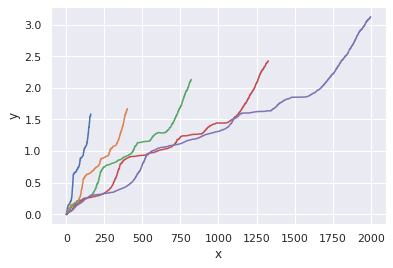

In [ ]:
final_profit_rate_usd_list = []
for NUM_OF_LINES in range(1,6):
  (list_buy_or_sell, trading_prices_history_status) = trade(SUB_TRADING_START_DATES)

  profit_rate_usd_list = calculate_profit()
  final_profit_rate_usd = profit_rate_usd_list[-1]
  final_profit_rate_usd_list.append(final_profit_rate_usd)

  df_result_plot = pd.DataFrame({'x':range(len(list_buy_or_sell)), 'y':profit_rate_usd_list[1:]})
  sns.lineplot(x='x', y='y', data=df_result_plot)

print('\n')
print('final_profit_rate_usd_list: ', final_profit_rate_usd_list)